Data PreProcessing

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Food_Delivery_Times.csv")

num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df["Courier_Experience_yrs"] = df["Courier_Experience_yrs"].fillna(df["Courier_Experience_yrs"].median()).astype(int)

df.to_csv("cleaned_dataset.csv", index=False)

X = df.drop(columns=["Delivery_Time_min", "Order_ID"])
y = df["Delivery_Time_min"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}, Test set: {X_test.shape}")

X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_valid = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_valid.to_csv("X_valid.csv", index=False)
y_valid.to_csv("y_valid.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

Train set: (700, 7), Validation set: (150, 7), Test set: (150, 7)


Batch Gradient

In [2]:
X_train = pd.read_csv("X_train.csv").values
y_train = pd.read_csv("y_train.csv").values.flatten()
X_valid = pd.read_csv("X_valid.csv").values
y_valid = pd.read_csv("y_valid.csv").values.flatten()
X_test = pd.read_csv("X_test.csv").values
y_test = pd.read_csv("y_test.csv").values.flatten()

num_features = X_train.shape[1]

In [3]:
def initialize_parameters(num_features):
    w = np.random.randn(num_features)
    b = np.random.randn()
    return w, b

In [4]:
def cal_gradient(X, pred_value, actual_value):

    dw = []

    error = pred_value - actual_value

    for i in range(X.shape[1]): 
        dw_feature = 2 * np.mean(X[:, i] * error)
        dw.append(dw_feature)
    
    dw = np.array(dw)

    db = 2 * np.mean(error)
    
    return dw, db

In [5]:
def cal_stochastic_gradient(X, pred_value, actual_value):
    error = pred_value - actual_value
    dw = (2 * X.T * error).flatten()
    db = 2 * error
    return dw, db

In [6]:
def batch_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations):
    train_MSE = []
    validation_MSE = []

    for i in range(0, num_iterations):
        pred_value = np.dot(X_train, w) + b
        mse_error = np.mean((pred_value - y_train) ** 2)
        train_MSE.append(mse_error)
        dw, db = cal_gradient(X_train, pred_value, y_train)

        if i%10 == 0:
            pred_value = np.dot(X_valid, w) + b
            mse_error = np.mean((pred_value - y_valid) ** 2)
            validation_MSE.append(mse_error)

        w -= learning_rate*dw
        b -= learning_rate*db

    return w, b, train_MSE, validation_MSE

In [7]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations, batch_size):
    train_MSE = []
    validation_MSE = []

    for i in range(0, num_iterations):
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        for j in range(0, len(X_train), batch_size):
            X_batch = X_train_shuffled[j:j+batch_size]
            y_batch = y_train_shuffled[j:j+batch_size]
            
            pred_value_batch = np.dot(X_batch, w) + b
            
            dw, db = cal_gradient(X_batch, pred_value_batch, y_batch)

            w -= learning_rate * dw
            b -= learning_rate * db

        pred_value = np.dot(X_train, w) + b
        mse_error = np.mean((pred_value - y_train) ** 2)
        train_MSE.append(mse_error)

        if(i % 10 == 0):
            pred_value = np.dot(X_valid, w) + b
            mse_error = np.mean((y_valid - pred_value) ** 2)
            validation_MSE.append(mse_error)

    return w, b, train_MSE, validation_MSE


In [8]:
def stochastic_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations):
    train_MSE = []
    validation_MSE = []

    for i in range(num_iterations):
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        for j in range(len(X_train)):
            X_sample = X_train_shuffled[j, :].reshape(1, -1)
            y_sample = y_train_shuffled[j]

            pred_value = np.dot(X_sample, w) + b
            dw, db = cal_stochastic_gradient(X_sample, pred_value, y_sample)

            w -= learning_rate * dw
            b -= learning_rate * db
        
        pred_value = np.dot(X_train, w) + b
        mse_error = np.mean((pred_value - y_train) ** 2)
        train_MSE.append(mse_error)

        if i % 10 == 0:
            pred_value = np.dot(X_valid, w) + b
            mse_error = np.mean((pred_value - y_valid) ** 2)
            validation_MSE.append(mse_error)

    return w, b, train_MSE, validation_MSE


In [9]:
def cal_and_plot(w, b, learning_rate_param, param, batch_size):


    learning_rate = learning_rate_param
    num_iterations = 1000

    if param == 1:
        w, b, train_MSE, validation_MSE = batch_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations)

    elif param == 2:
        w, b, train_MSE, validation_MSE = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations, batch_size)
    
    elif param == 3:
        w, b, train_MSE, validation_MSE = stochastic_gradient_descent(X_train, y_train, X_valid, y_valid, w, b, learning_rate, num_iterations)

    pred_value_test = np.dot(X_test, w) + b
    MSE_test = np.mean(( pred_value_test - y_test) ** 2)
    print(f"MSE for test_set is {MSE_test}")

    R2_denom = np.mean((y_test - np.mean(y_test)) ** 2)

    print(f"The value of R2 is {1 - (MSE_test / R2_denom)}")

    print(f"Final weights: {w}")
    print(f"Final bias: {b}")

    plt.figure(figsize=(8, 6))
    plt.plot(train_MSE, label="MSE")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss over Iterations during Gradient Descent")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(validation_MSE, label="MSE")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss over Iterations during Gradient Descent")
    plt.legend()
    plt.grid(True)
    plt.show()


MSE for test_set is 82.37543136713207
The value of R2 is 0.8016013633687056
Final weights: [16.78662647  2.15008092 -1.3592713  -0.40010121 -0.20572261  7.04597624
 -1.83875615]
Final bias: 57.30428571428568


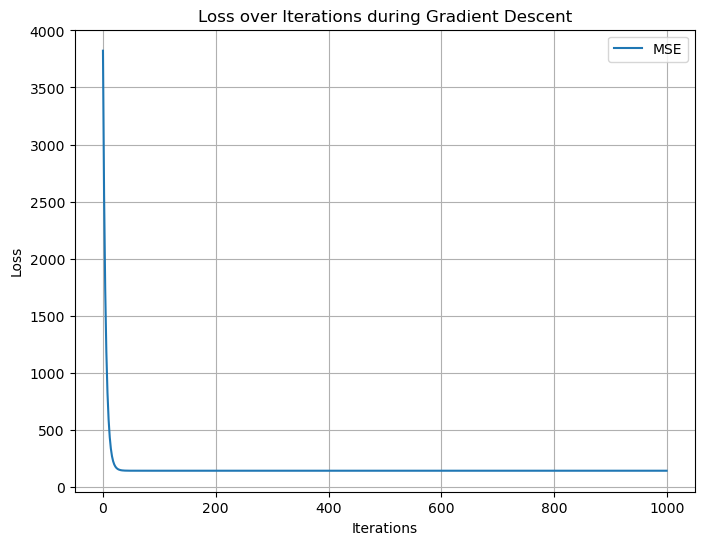

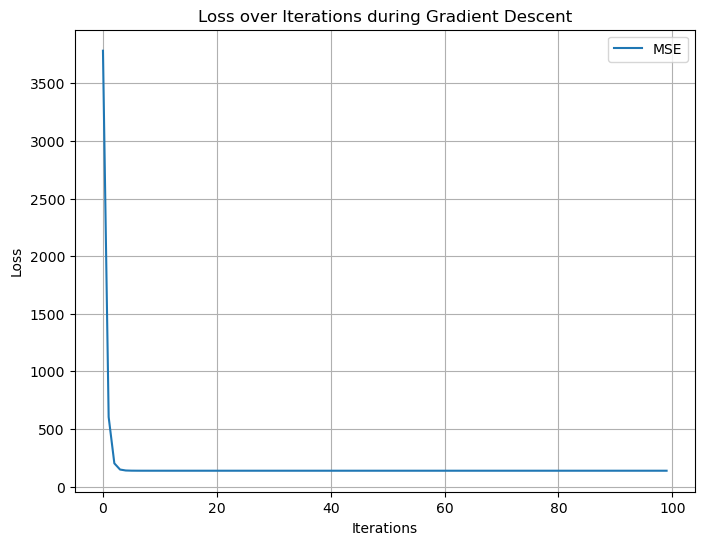

In [10]:
w, b = initialize_parameters(num_features)

learning_rate = 0.05
cal_and_plot(w,b, learning_rate, 1, 0)

MSE for test_set is 82.37543136713208
The value of R2 is 0.8016013633687056
Final weights: [16.78662647  2.15008092 -1.3592713  -0.40010121 -0.20572261  7.04597624
 -1.83875615]
Final bias: 57.30428571428568


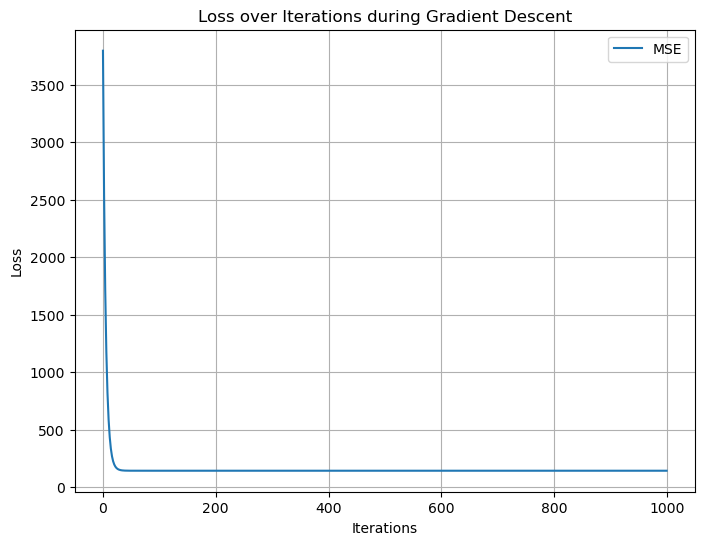

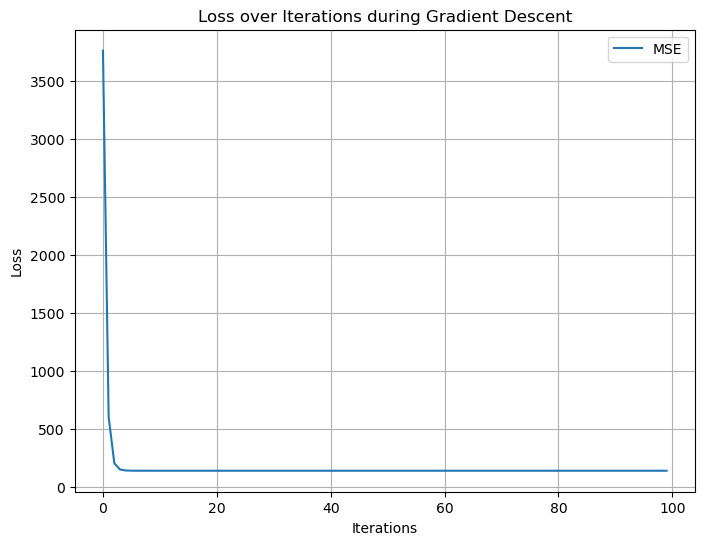

In [11]:
w = [0] * 7

learning_rate = 0.05
cal_and_plot(w, b, learning_rate, 1, 0)

MSE for test_set is 82.33934293904964
The value of R2 is 0.8016882812131513
Final weights: [16.85843032  2.11870684 -1.48363427 -0.60119797  0.18885499  6.80015913
 -1.42299547]
Final bias: 57.31456766022862


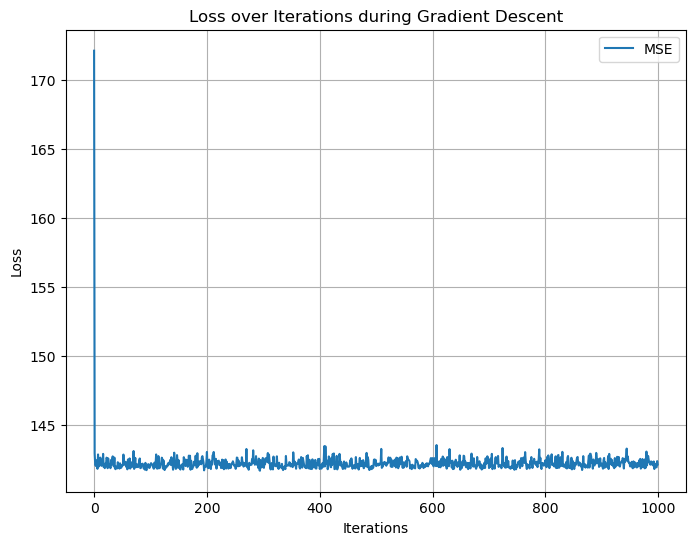

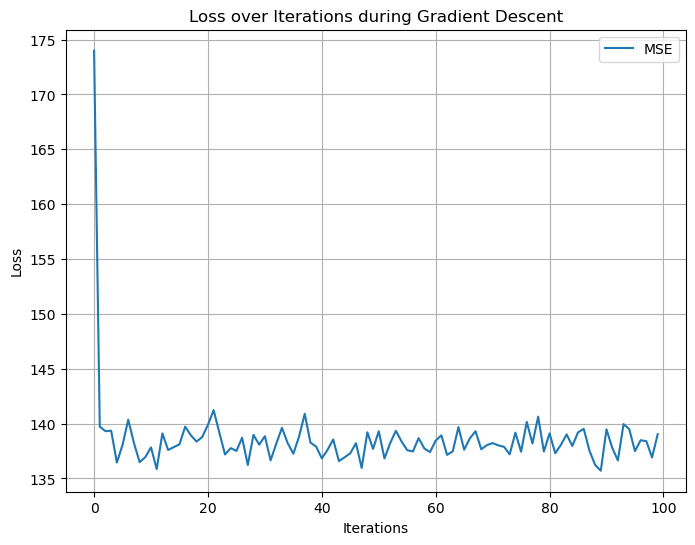

In [12]:
w, b = initialize_parameters(num_features)

learning_rate = 0.05
cal_and_plot(w,b, learning_rate, 2, 32)

MSE for test_set is 84.40601559908552
The value of R2 is 0.7967107650859594
Final weights: [ 1.64614772e+01  1.93365001e+00 -1.44815005e+00 -7.42424177e-01
  3.10033629e-03  7.16615834e+00 -1.98683568e+00]
Final bias: 57.37942819893728


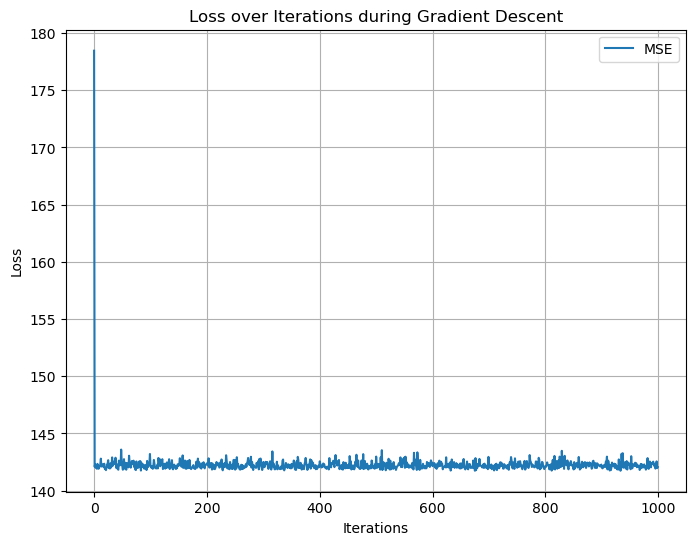

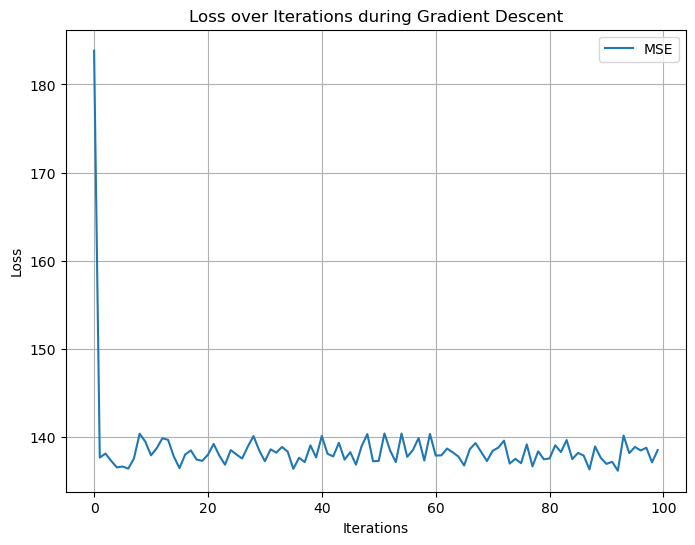

In [13]:
w = [0] * 7

learning_rate = 0.05
cal_and_plot(w,b, learning_rate, 2, 32)

MSE for test_set is 352.6724100200652
The value of R2 is 0.1505995881998886
Final weights: [12.60839734 11.38969505 -6.63483374 -1.29957584 -2.03256073  5.00065888
 -7.39141646]
Final bias: [65.2432782]


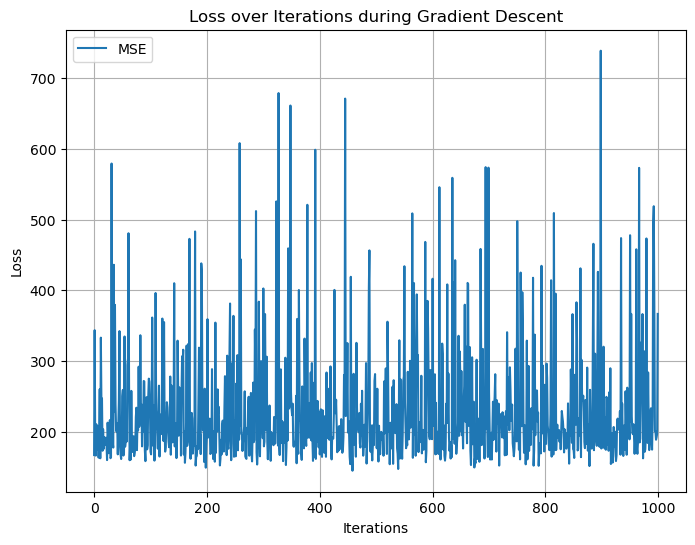

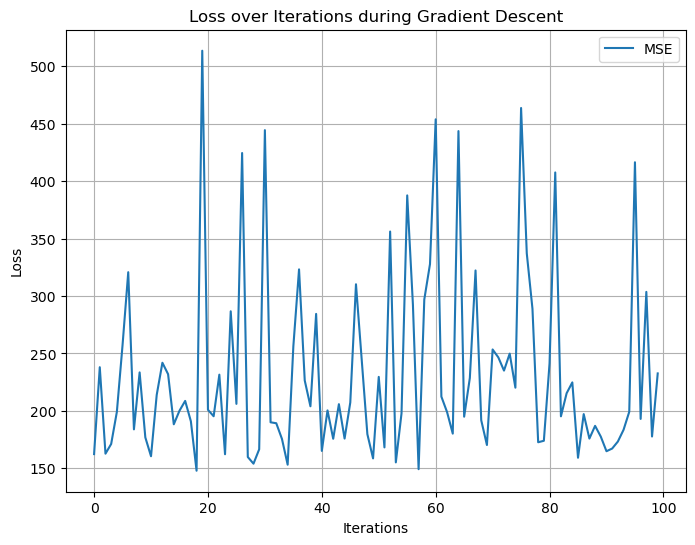

In [14]:
w, b = initialize_parameters(num_features)

learning_rate = 0.05
cal_and_plot(w,b, learning_rate, 3, 1)

MSE for test_set is 93.91213793248161
The value of R2 is 0.7738155683107155
Final weights: [17.39277965  2.38565199  0.51565962  1.86884632 -1.77953728  7.2870593
 -3.23317028]
Final bias: [54.1865479]


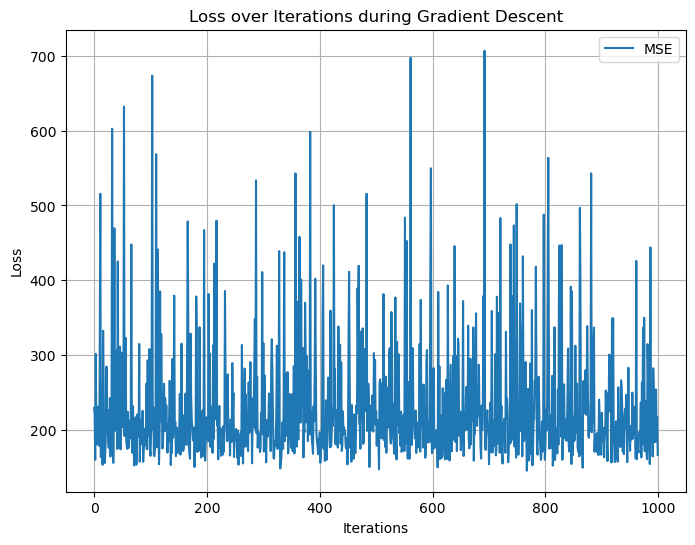

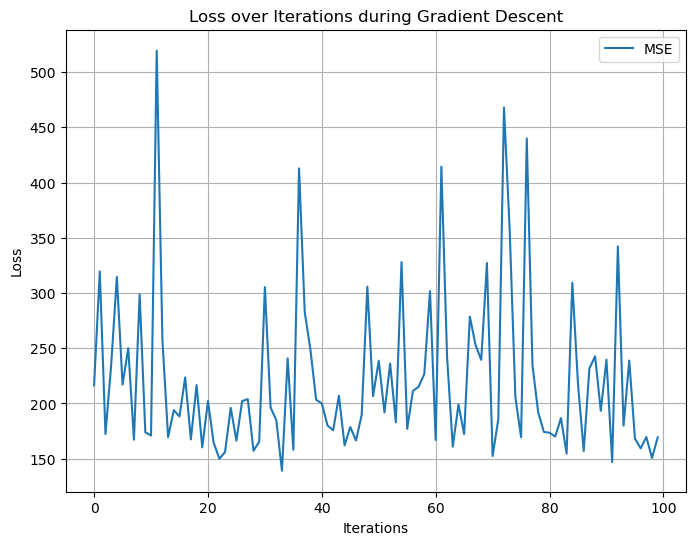

In [15]:
w = [0] * 7

learning_rate = 0.05
cal_and_plot(w,b, learning_rate, 3, 1)